# Video game clustering

## Model building

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Imputation of missing values
from fancyimpute import KNN

# Models
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Load processed data

In [2]:
data = pd.read_csv("video_games_processed.csv")

## Encode categorical features

In [3]:
data.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
0,DOOM,id Software,92.0,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,49.0,836608.0,True,True
2,BATTLETECH,Harebrained Schemes,71.0,7030.0,True,False
3,DayZ,Bohemia Interactive,61.0,167115.0,True,False
4,EVE Online,CCP,74.0,11481.0,True,False


In [4]:
categorical_columns = ['name', 'developer', 'multiplayer', 'mature']
enc = OrdinalEncoder()
data[categorical_columns] = enc.fit_transform(data[categorical_columns])

In [5]:
data.head()

,name,developer,percent_positive,num_reviews,multiplayer,mature
0,7498.0,16796.0,92.0,42550.0,1.0,0.0
1,23455.0,10728.0,49.0,836608.0,1.0,1.0
2,2749.0,6329.0,71.0,7030.0,1.0,0.0
3,7963.0,2031.0,61.0,167115.0,1.0,0.0
4,9902.0,2343.0,74.0,11481.0,1.0,0.0


## Train-test split



In [6]:
train, test = train_test_split(data, test_size=0.2)
print(f"Training data size = {train.shape}")
print(f"Test data size = {test.shape}")

Training data size = (32598, 6)
Test data size = (8150, 6)


## Principal Component Analysis (PCA)

* Reduce our features to just 2
* KMeans algorithm (for clustering) doesn't work well in high dimensions

In [7]:
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train)
test_pca = pca.fit_transform(test)

In [8]:
explained = pca.explained_variance_ratio_
print(f"Cumulative variance explained by 2 principal components: {round(100 * np.sum(explained), 1)}%")

Cumulative variance explained by 2 principal components: 92.3%


In [9]:
# Features by importance
dataset_pca = pd.DataFrame(abs(pca.components_), columns=train.columns, index=['PC_1', 'PC_2'])
dataset_pca


,name,developer,percent_positive,num_reviews,multiplayer,mature
PC_1,0.127896,0.001115,0.000022,0.991787,0.000002,1.361434e-06
PC_2,0.991043,0.038585,0.000040,0.127844,0.000003,1.964534e-07


In [24]:
importance_threshold = 0.3
print(f"Most important features (must exceed {importance_threshold}):")
print('PC 1:\n', (dataset_pca[dataset_pca > importance_threshold].iloc[0]).dropna().to_string())   
print('\nPC 2:\n', (dataset_pca[dataset_pca > importance_threshold].iloc[1]).dropna().to_string())
print("\n")


Most important features (must exceed 0.3):
PC 1:
 num_reviews    0.991787

PC 2:
 name    0.991043




## Choosing the number of clusters for K-Means

Two methods are commonly used to determine how many clusters to choose:
* Elbow method
* Silhouette method


### Elbow method

* Choose a range of candidate values of K (e.g. 1 to 10)
* Calculate the average distance from centroid for each value
* Plot and find "elbow"


### Silhouette method

* Choose a range of candidate values of K (e.g. 1 to 10)
* Plot silhouettes for each value of K
* Silhouette calculation:
  * Let a(i) = average distance from i to all points within same cluster
  * Let b(i) = average distance from i to all points from closest neighbouring cluster
  * Silhoutte cofficient s(i) = (b(i) - a(i)) / larger of b(i) and a(i)
* Ideal silhouette value = 1
* Worst possible silhouette value = -1


### Elbow method to identify number of clusters

* K is number of clusters
* We repeat the calculation setting K to 1 to 12 in a loop
* The WSS (Within-Cluster-Sum of squared) score is calculated for each value of K


In [11]:
def clusters_elbow(data, max_k):
    K = range(1, max_k)
    wss = []
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++')
        kmeans.fit(data)
        wss_iter = kmeans.inertia_
        wss.append(wss_iter)
    cluster_centres = pd.DataFrame({'Clusters': K, 'WSS': wss})
    return cluster_centres

In [12]:
clusters_train = clusters_elbow(data=train_pca, max_k=12)
clusters_test = clusters_elbow(data=test_pca, max_k=12)


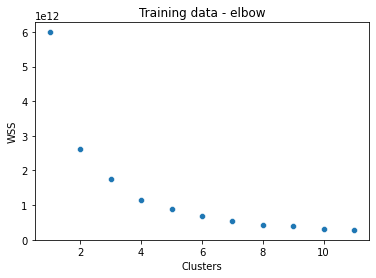

In [13]:
# Elbow plot for training data
sns.scatterplot(x='Clusters', y='WSS', data=clusters_train, marker="o")
plt.title("Training data - elbow")
plt.show()

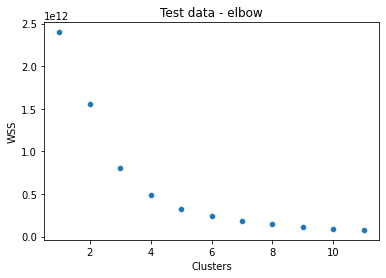

In [14]:
# Elbow plot for test data
sns.scatterplot(x='Clusters', y='WSS', data=clusters_test, marker="o")
plt.title("Test data - elbow")
plt.show()

### Silhouette method to identify number of clusters

In [15]:
def clusters_silhouette(data, max_k):
    for k in range(2, max_k+1):
        clusterer = KMeans(n_clusters=k, init='k-means++', random_state=200)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = metrics.silhouette_score(data, cluster_labels)
        print(f"Silhouette score for {k} clusters = {silhouette_avg}")

In [16]:
print("Training data")
clusters_silhouette(data=train_pca, max_k=12)

Training data
Silhouette score for 2 clusters = 0.5967765379348898
Silhouette score for 3 clusters = 0.6019491379118691
Silhouette score for 4 clusters = 0.5514273930196296
Silhouette score for 5 clusters = 0.5566455852924208
Silhouette score for 6 clusters = 0.5271543814937187
Silhouette score for 7 clusters = 0.5280090396536142
Silhouette score for 8 clusters = 0.5095718317878285
Silhouette score for 9 clusters = 0.5107303076028521
Silhouette score for 10 clusters = 0.4919265005031299
Silhouette score for 11 clusters = 0.5003849660783339
Silhouette score for 12 clusters = 0.4792861341750178
